In [4]:
# Importing required libraries
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import utils

In [5]:
# Processing the data
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
# Parameters
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden = 128 # hidden layer size
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
tilda_X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'decoder_h': tf.Variable(tf.random_normal([n_hidden, n_input])),
}
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])),
    'decoder_b': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation
    hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                 biases['encoder_b']))
    return hidden


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation
    output = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h']),
                                 biases['decoder_b']))
    return output

# Construct model
encoder_op = encoder(tilda_X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [7]:
# Initializing the variables
init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            tilda_batch_xs = utils.add_gblur(batch_xs)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs,
                                                         tilda_X: tilda_batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))    
    
    print("Optimization Finished!")
    
    # Visualizing the weights
    W = weights['encoder_h'].eval()    
    np.save('saves/gblur_weights.npy',W)
    
    tilda_test = utils.add_gblur(mnist.test.images)
    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show],
                           tilda_X: tilda_test[:examples_to_show]})

Epoch: 0001 cost= 0.173573554
Epoch: 0002 cost= 0.106515825
Epoch: 0003 cost= 0.090955809
Epoch: 0004 cost= 0.083853178
Epoch: 0005 cost= 0.076155335
Epoch: 0006 cost= 0.072080657
Epoch: 0007 cost= 0.065718003
Epoch: 0008 cost= 0.063324116
Epoch: 0009 cost= 0.061630946
Epoch: 0010 cost= 0.059689857
Epoch: 0011 cost= 0.059210923
Epoch: 0012 cost= 0.056353431
Epoch: 0013 cost= 0.055700127
Epoch: 0014 cost= 0.055362601
Epoch: 0015 cost= 0.054458003
Epoch: 0016 cost= 0.052141115
Epoch: 0017 cost= 0.049287893
Epoch: 0018 cost= 0.051111933
Epoch: 0019 cost= 0.049708631
Epoch: 0020 cost= 0.046632018
Optimization Finished!


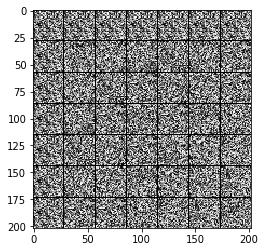

In [8]:
W = np.load('saves/gblur_weights.npy')
vis_w = utils.visualize(W.T, [28, 28], [1, 1], [7, 7])
plt.imshow(vis_w, cmap='gray')
plt.draw()
plt.savefig('saves/gblur_weights_vis.png')
plt.show()

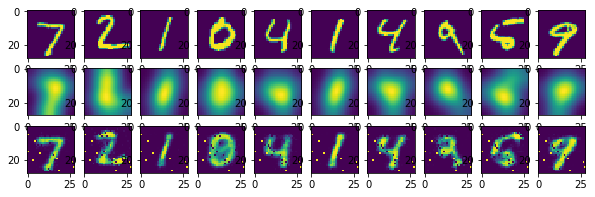

In [9]:
# Compare original images with their reconstructions
f, a = plt.subplots(3, 10, figsize=(10, 3))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(tilda_test[i], (28, 28)))
    a[2][i].imshow(np.reshape(encode_decode[i], (28, 28)))
plt.draw()
plt.savefig('saves/gblur_test_visu.png')
plt.show()